In [1]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt



In [3]:
data = pd.read_excel('./data/отзывы за лето.xls')
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
data.shape

(20659, 3)

In [5]:
data =  data.loc[data['Rating']!=3]
data.shape

(19748, 3)

In [6]:
conditions = [
(data['Rating'] < 3),    
(data['Rating'] > 3)]
choices = [0, 1]

data['Rating'] = np.select(conditions, choices, default = 5)

In [7]:
data['Rating'].value_counts()

1    16724
0     3024
Name: Rating, dtype: int64

### Предобработка

In [8]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [9]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

data['Content'] = data['Content'].apply(preprocess_text)


train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=42)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

In [10]:
train_corpus = " ".join(train["Content"])
train_corpus = train_corpus.lower()

In [11]:
import nltk
from nltk.tokenize import word_tokenize
# nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LSK-17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
tokens_filtered_top[10:15]

['быстро', 'обновление', 'мочь', 'сбербанк', 'антивирус']

In [15]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [16]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [17]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["Content"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in valid["Content"]], dtype=np.int32)

In [18]:
train.shape

(7899, 3)

In [20]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   73,   98,   22,
         32,  271,   28,    1,   10, 1221,  547])

# Keras model

In [21]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [34]:
num_classes = 2
y_train = keras.utils.to_categorical(train["Rating"], num_classes)
y_test = keras.utils.to_categorical(test["Rating"], num_classes)
y_valid = keras.utils.to_categorical(valid["Rating"], num_classes)

In [23]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
 1/14 [=>............................] - ETA: 0s - loss: 0.6998 - accuracy: 0.3691WARNING:tensorflow:From D:\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
14/14 [==============================] - 1s 57ms/step - loss: 0.5177 - accuracy: 0.8145 - val_loss: 0.4094 - val_accuracy: 0.8354
Epoch 2/20
14/14 [==============================] - 1s 43ms/step - loss: 0.3723 - accuracy: 0.8495 - val_loss: 0.3581 - val_accuracy: 0.8380
Epoch 3/20
14/14 [==============================] - 1s 39ms/step - loss: 0.2938 - accuracy: 0.8785 - val_loss: 0.2777 - val_accuracy: 0.8835
Epoch 4/20
14/14 [==============================] - 1s 39ms/step - loss: 0.2144 - accuracy: 0.9173 - val_loss: 0.2377 - val_accuracy: 0.9063
Epoch 5/20
14/14 [==============================] - 1s 39ms/step - loss: 0.

In [26]:
score = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 9ms/step - loss: 0.1823 - accuracy: 0.9218


Test score: 0.182294100522995
Test accuracy: 0.9218433499336243


In [30]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

12/12 [==============================] - 0s 9ms/step


In [35]:
print(f'Test score: {round(roc_auc_score(y_test, results),3)}')

Test score: 0.953


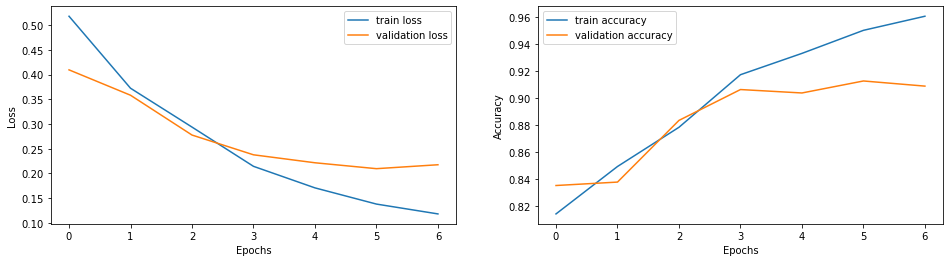

In [38]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()